In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":,:]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?


Bad key savefig.frameon in file /Users/jeff/opt/anaconda3/envs/dev/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/jeff/opt/anaconda3/envs/dev/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/jeff/opt/anaconda3/envs/dev/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.s

<AxesSubplot:xlabel='Date'>

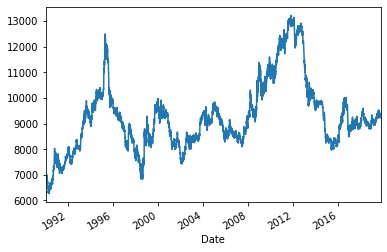

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot.line()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
df=pd.concat([yen_futures.Settle,ts_noise,ts_trend],join='outer',axis='columns')
df.columns

Index(['Settle', 'Settle_cycle', 'Settle_trend'], dtype='object')

<AxesSubplot:title={'center':'Hodrick-Prescott Filter Decomposition'}, xlabel='Date'>

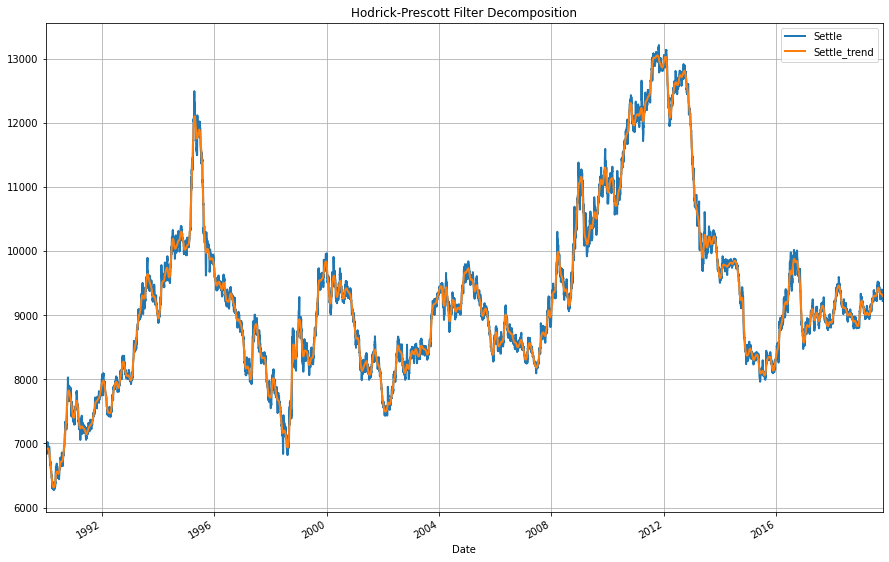

In [34]:
# Plot the Settle Price vs. the Trend for 2015 to the present
df.plot.line(y=(['Settle','Settle_trend']),title='Hodrick-Prescott Filter Decomposition',figsize=(15,10),grid=True,lw=2)

<AxesSubplot:title={'center':'Hodrick-Prescott Filter Noise'}, xlabel='Date'>

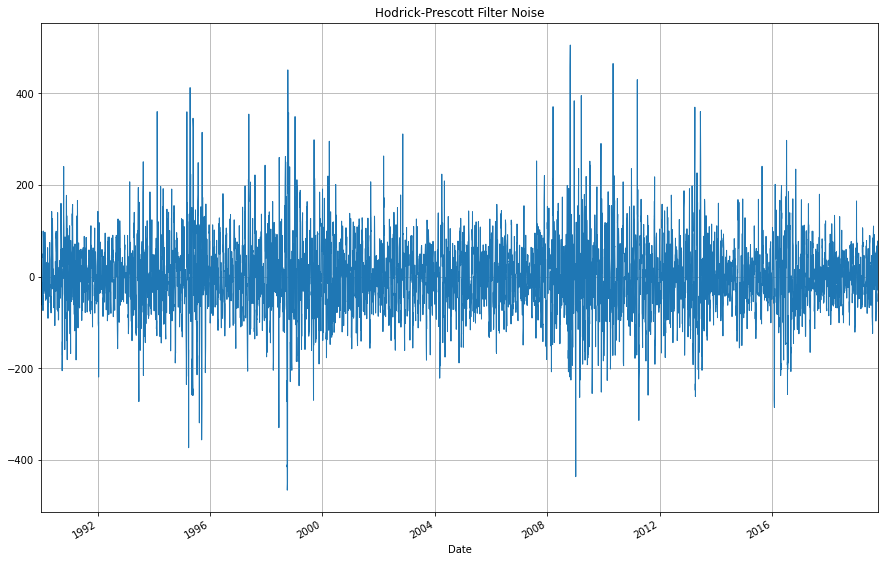

In [35]:
# Plot the Settle Noise
df.Settle_cycle.plot.line(title='Hodrick-Prescott Filter Noise',figsize=(15,10),grid=True,lw=1)

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7514 entries, 1990-01-03 to 2019-10-15
Data columns (total 1 columns):
Settle    7514 non-null float64
dtypes: float64(1)
memory usage: 117.4 KB


In [44]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings("ignore")
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model= ARMA(returns.values, order=(2,1))
# Fit the model and assign it to a variable called results
results = model.fit()
results

In [58]:
# Output model summary results:
results.summary()
# import matplotlib.pyplot as plt
# plt.rc('figure', figsize=(12, 7))
# plt.text(0.01, 0.05, str(results.summary()), {'fontsize': 10}, fontproperties = 'monospace')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('ARMA_MODEL_RESULTS.png')

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Mon, 08 Mar 2021   AIC                          15798.142
Time:                        17:51:43   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2947      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3349           +0.0000j            3.3349            0.5000
AR.2         -157.1502           +0.0000j          157.1502            0.5000
MA.1           -3.3938           +0.0000j            3.3938            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Return Forecasted'}>

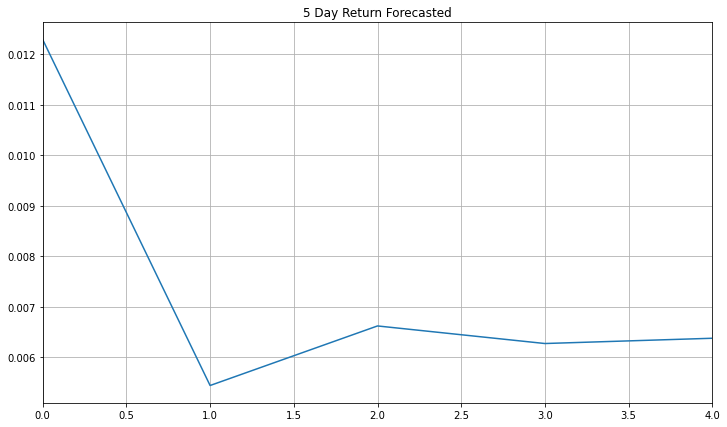

In [60]:
# Plot the 5 Day Returns Forecast
pd.Series(results.forecast(steps=5)[0]).plot(title='5 Day Return Forecasted',grid=True)

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [65]:
from statsmodels.tsa.arima_model import ARIMA
model =ARIMA(yen_futures['Settle'],order=(5,1,1,))
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!

# Fit the model
results = model.fit()

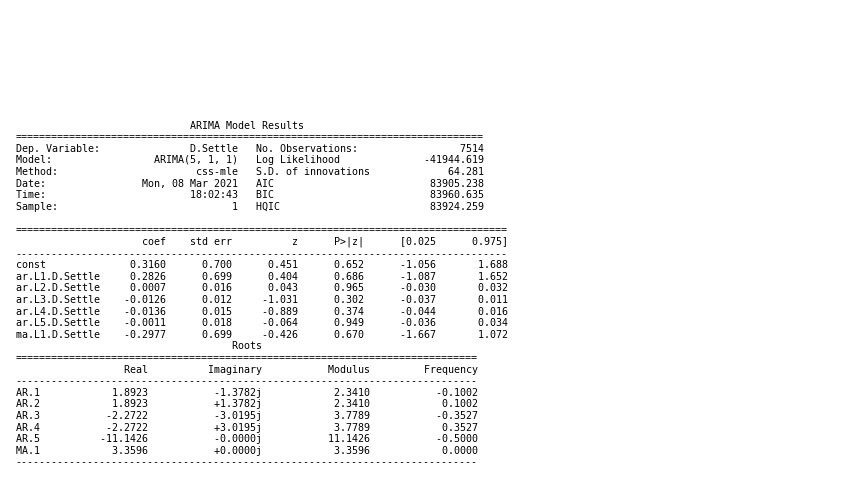

In [67]:
# Output model summary results:
results.summary()
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(results.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('ARIMA_MODEL_RESULTS.png')

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

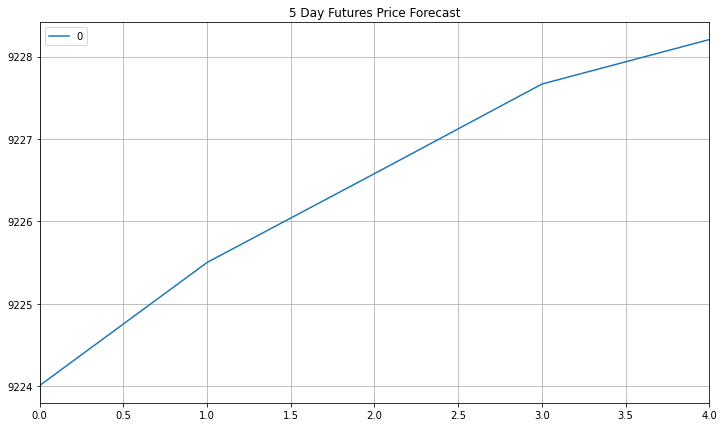

In [68]:
# Plot the 5 Day Price Forecast

pd.DataFrame(results.forecast(steps=5)[0]).plot(title='5 Day Futures Price Forecast',grid=True)


---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [69]:
from arch import arch_model

In [70]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
res = model.fit(update_freq=5)

Iteration:      5,   Func. Count:     34,   Neg. LLF: 7479.053903182994
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7461.935968239088
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7461.927640079675
            Iterations: 14
            Function evaluations: 81
            Gradient evaluations: 14


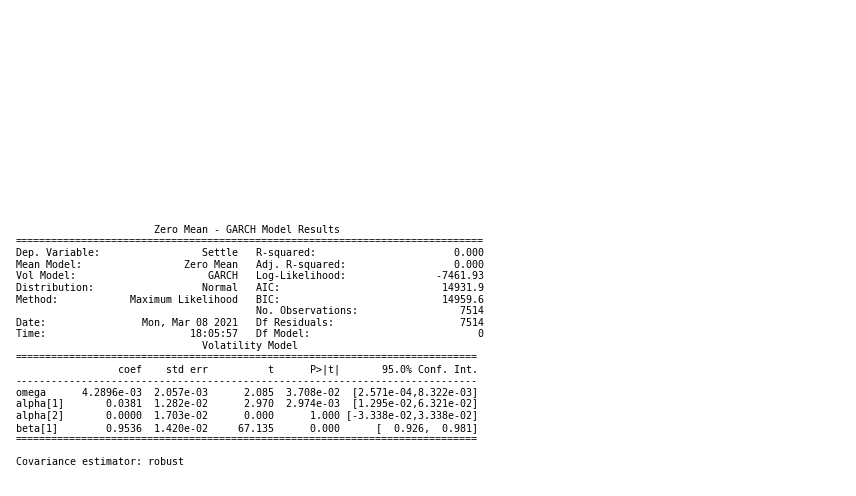

In [71]:
# Summarize the model results
res.summary()
# import matplotlib.pyplot as plt
# plt.rc('figure', figsize=(12, 7))
# plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('GARCH_MODEL_RESULTS.png')

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)

In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15 00:00:00
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


<AxesSubplot:title={'center':'5 Day Price Forecast'}>

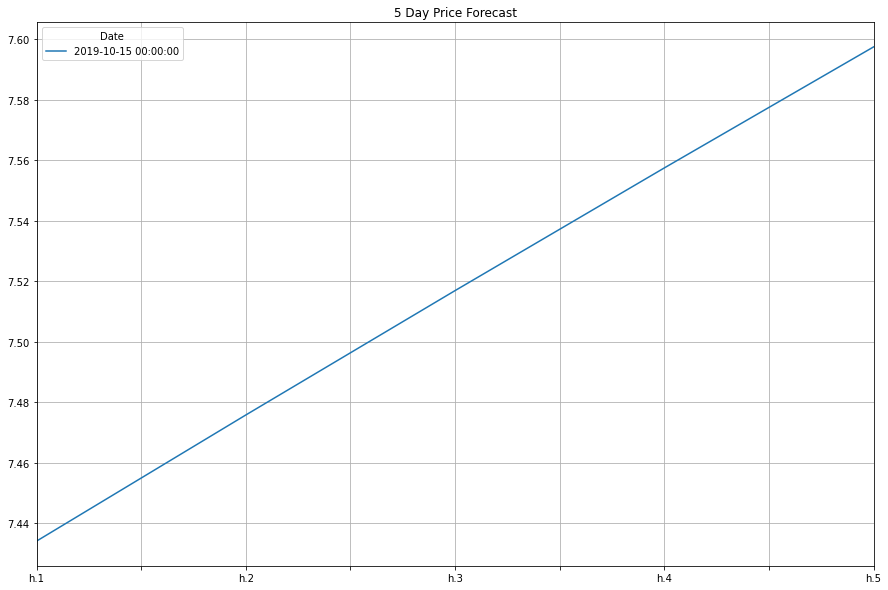

In [72]:
# Plot the final forecast
final.plot(title='5 Day Price Forecast',grid=True,figsize=(15,10))

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?